# Paralelizando prophet

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
from prophet import Prophet
from dask.distributed import LocalCluster, Client

In [3]:
def random_walk_generator(n):
    steps = np.random.standard_normal(n)
    steps[0] = 0
    return np.cumsum(steps)

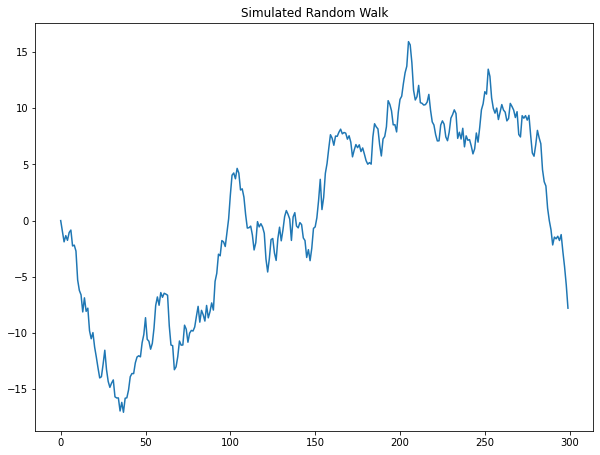

In [4]:
plt.figure(figsize=[10, 7.5]); # Set dimensions for figure
plt.plot(random_walk_generator(300))
plt.title("Simulated Random Walk")
plt.show()

In [5]:
times = pd.date_range('2012-10-01', periods=100, freq='1D')

In [6]:
df = pd.DataFrame(columns = {"ds", "y", "dimension"})
for column in range(30):
    aux_df = pd.DataFrame({"ds": times, "y": random_walk_generator(100), "dimension": column})
    df = df.append(aux_df)

In [7]:
def prophet_forecast(df):
    model = Prophet(changepoint_prior_scale=0.5)
    model.fit(df)
    future = model.make_future_dataframe(periods=10)
    forecast = model.predict(future)
    result = forecast[["ds", 'yhat', "yhat_lower", "yhat_upper"]]
    return result

In [8]:
ddf = dd.from_pandas(df, npartitions = 30)
meta = {"ds":"datetime64[ns]", 
        "yhat": "float64", 
        "yhat_lower": "float64", 
        "yhat_upper": "float64"}
grouped = ddf.groupby("dimension").apply(prophet_forecast, meta = meta)

In [9]:
ClusterWorkers=8
ThreadPerWorker=1
cluster = LocalCluster(n_workers=ClusterWorkers, threads_per_worker=ThreadPerWorker, memory_limit='2GB')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45697,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:43847,Total threads: 1
Dashboard: http://127.0.0.1:34281/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:35411,


In [10]:
%%time
df.groupby("dimension").apply(prophet_forecast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgky6uf88/zo5x0pvj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgky6uf88/ispijnhb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67533', 'data', 'file=/tmp/tmpgky6uf88/zo5x0pvj.json', 'init=/tmp/tmpgky6uf88/ispijnhb.json', 'output', 'file=/tmp/tmp74jv9r6y/prophet_model-20220924184443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yea

CPU times: user 1min 22s, sys: 7.36 s, total: 1min 29s
Wall time: 1min 35s


ds       yhat  yhat_lower  yhat_upper
dimension                                                  
0         0   2012-10-01  -1.353436   -2.973176    0.296161
          1   2012-10-02  -1.779396   -3.347406   -0.187689
          2   2012-10-03  -2.413383   -3.925524   -0.690999
          3   2012-10-04  -2.927054   -4.643421   -1.343500
          4   2012-10-05  -3.191910   -4.779688   -1.586840
...                  ...        ...         ...         ...
29        105 2013-01-14  12.531091   10.731760   14.259424
          106 2013-01-15  12.760226   11.034416   14.609247
          107 2013-01-16  13.038683   11.371026   14.680525
          108 2013-01-17  12.845504   11.049870   14.504795
          109 2013-01-18  12.950279   11.326857   14.807587

[3300 rows x 4 columns]

In [11]:
%%time 
grouped.compute(num_workers = ClusterWorkers)

CPU times: user 11.2 s, sys: 1.62 s, total: 12.8 s
Wall time: 1min 30s


ds      yhat  yhat_lower  yhat_upper
dimension                                                 
21        0   2012-10-01  0.217307   -0.914012    1.352384
          1   2012-10-02 -0.439872   -1.590975    0.781294
          2   2012-10-03 -0.305224   -1.393762    0.803414
          3   2012-10-04 -0.276603   -1.319705    0.861773
          4   2012-10-05 -0.183248   -1.302311    1.065833
...                  ...       ...         ...         ...
6         105 2013-01-14 -1.164379   -2.418523    0.151409
          106 2013-01-15 -1.415794   -2.618733   -0.085774
          107 2013-01-16 -1.424322   -2.703054   -0.139329
          108 2013-01-17 -1.535425   -2.728428   -0.189744
          109 2013-01-18 -1.143299   -2.450070    0.113308

[3300 rows x 4 columns]